In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import sys
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.optim import SGD, Adam
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models

sys.path.append("python")
from utils import print_parameters

In [2]:
checkpoint_path = "../model_weights/PDDD/ResNet50-Plant-model-80.pth"
num_classes_weights = 120
num_classes_classifier = 28
img_size = 224
data_dir = "../datasets/PlantDoc-Dataset-windows-compatible/train/"
batch_size_train = 16
batch_size_valid = 16
validation_ratio = 0.2
seed = 19
run_path = "../runs/ResNet50_PlantDoc"

In [3]:
if not os.path.exists(run_path):
    os.mkdir(run_path)

In [4]:
assert torch.cuda.is_available()
n_devices = torch.cuda.device_count()
for i in range(0, n_devices):
    print(torch.cuda.get_device_name(i))

# device = torch.device("cuda")
device = torch.device("cpu")

NVIDIA GeForce GTX 960


In [5]:
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes_weights)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.fc = nn.Linear(model.fc.in_features, num_classes_classifier)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layers
for param in model.fc.parameters():
    param.requires_grad = True

_, param_count_required = print_parameters(model)

# Validity check: weight and bias for every output node
assert param_count_required == (model.fc.in_features + 1) * num_classes_classifier

params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# optimizer = Adam(params, lr=0.001)
loss_function = nn.CrossEntropyLoss()

Total parameters: 23565404
Required parameters: 57372 


In [6]:
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
    ]
)
ds_full = datasets.ImageFolder(data_dir, transform=transform)

In [7]:
size_full = len(ds_full)
size_valid = int(validation_ratio * size_full)
size_train = size_full - size_valid
ds_train, ds_valid = data.random_split(
    ds_full, [size_train, size_valid], generator=torch.Generator().manual_seed(seed)
)
print(f"Split into {len(ds_train)} train and {len(ds_valid)} validation data points")

Split into 1874 train and 468 validation data points


In [8]:
dl_train = data.DataLoader(
    ds_train,
    batch_size=batch_size_train,
    shuffle=False,
    num_workers=0,
)

dl_valid = data.DataLoader(
    dataset=ds_valid,
    batch_size=batch_size_valid,
    shuffle=False,
    num_workers=0,
)

ok


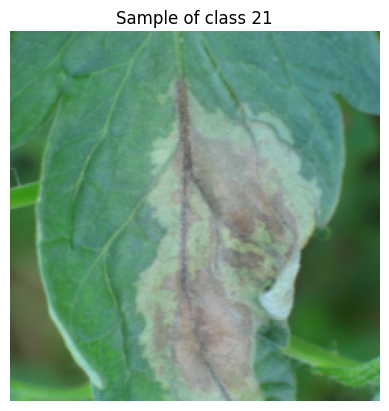

In [9]:
images, labels = next(iter(dl_valid))
img = images[0].cpu().numpy().transpose((1, 2, 0))
plt.axis("off")
plt.title(f"Sample of class {labels[0]}")
plt.imshow(img)
print("ok")

In [10]:
# possible_labels = []
# for _, labels in dl_train:
#     possible_labels.append(labels.item())

# # validity check: classes
# assert 0 == min(possible_labels)
# assert num_classes_classifier == max(possible_labels) + 1

In [11]:
model.eval()
# images = images.to(device)
outputs = model(images)

probs = softmax(outputs[0].cpu().detach().numpy())
max_idx = np.argmax(probs)
print(f"category {max_idx} with probability {probs[max_idx]} ")

category 17 with probability 0.03680020943284035 


In [12]:
# model.train()
# outputs = model(images)
# loss = loss_function(outputs, labels)
# print(loss.item())

In [17]:
def train_eval(
    model,
    optimizer,
    criterion,
    start_epoch,
    end_epoch,
    data_loader_train,
    data_loader_valid,
):
    # TODO: load model if needed
    model = model.to(device)
    model.train()
    for epoch in range(start_epoch, end_epoch):
        print(f"Start training epoch {epoch}")
        i = 0
        for images, targets in data_loader_train:
            i += 1
            # images = list(img.to(device) for img in images)
            # targets = list(t.to(device) for t in targets)
            outputs = model(images)
            loss = criterion(outputs, targets)
            with open(f"{run_path}/loss.txt", "a") as detaillog:
                line = {}
                line["epoch"] = epoch
                line["iteration"] = i
                line["loss"] = loss.item()
                line["set"] = "train"
                json.dump(line, detaillog, indent=2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        torch.save(
            model.state_dict(),
            f"{run_path}/checkpoint_{epoch}.pth",
        )

        with torch.no_grad():
            i = 0
            for images, targets in data_loader_valid:
                i += 1
                # images = list(img.to(device) for img in images)
                # targets = list(t.to(device) for t in targets)
                outputs = model(images)
                loss = criterion(outputs, targets)
                with open("../runs/ResNet50_PlantDoc/loss.txt", "a") as detaillog:
                    line = {}
                    line["epoch"] = epoch
                    line["iteration"] = i
                    line["loss"] = loss.item()
                    line["set"] = "valid"
                    json.dump(line, detaillog, indent=2)

In [18]:
start_epoch = 0
end_epoch = 50
train_eval(model, optimizer, loss_function, start_epoch, end_epoch, dl_train, dl_valid)

Start training epoch 0
Start training epoch 1
Start training epoch 2
Start training epoch 3
Start training epoch 4
Start training epoch 5
Start training epoch 6
Start training epoch 7
Start training epoch 8
Start training epoch 9
Start training epoch 10
Start training epoch 11
Start training epoch 12
Start training epoch 13
Start training epoch 14
Start training epoch 15
Start training epoch 16
Start training epoch 17
Start training epoch 18
Start training epoch 19
Start training epoch 20
Start training epoch 21
Start training epoch 22
Start training epoch 23
Start training epoch 24
Start training epoch 25
Start training epoch 26
Start training epoch 27
Start training epoch 28
Start training epoch 29
Start training epoch 30
Start training epoch 31
Start training epoch 32
Start training epoch 33
Start training epoch 34
Start training epoch 35
Start training epoch 36
Start training epoch 37
Start training epoch 38
Start training epoch 39
Start training epoch 40
Start training epoch 41
St